In [1]:
import tensorflow as tf

2023-09-21 23:27:20.905364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 23:27:20.933865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 23:27:22.081960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion, gaussian_filter, zoom

from scipy.stats import wilcoxon
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

from IPython import display
import datetime
import cv2
from Architectures import ESRGAN

from data_loader import load_data
from sr_utility import space_to_depth, depth_to_space

from data_utils import calc_MD_FA_CFA

from IPython.display import clear_output

import model

In [4]:
subjects = [ f.name for f in os.scandir('../HCPData') if f.is_dir() and f.name != '.ipynb_checkpoints' and f.name !=  'TrainingData']

subjects = ['390645', '545345', '106016', '120111', '101915', '351938', '705341', '951457']

# subjects = ['390645']

ds = 2

e_or_o = 0

LAMBDA = 1000

p_size_i = 8
p_size_o = 8

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341', '951457']


In [6]:
generator = ESRGAN.srgan_gen_multmode()
discriminator = ESRGAN.srgan_disc()

2023-09-21 23:27:29.836441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 23:27:29.852882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 23:27:29.853000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

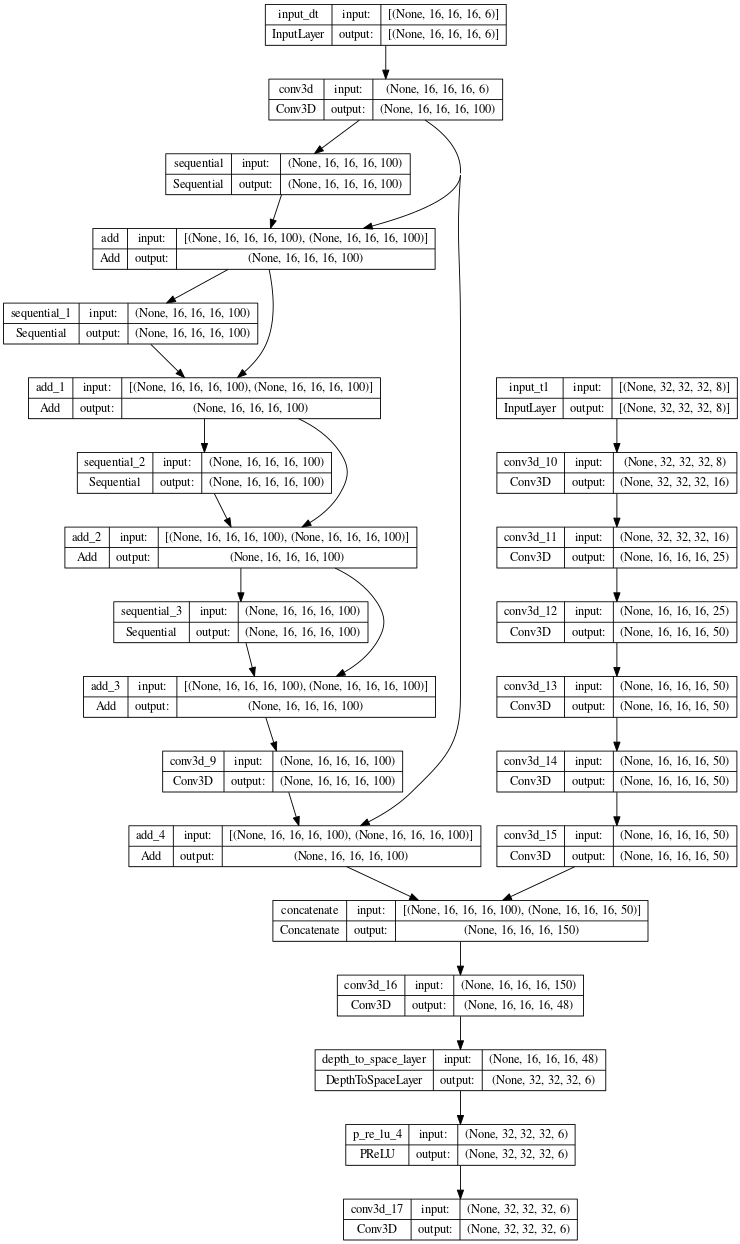

In [7]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

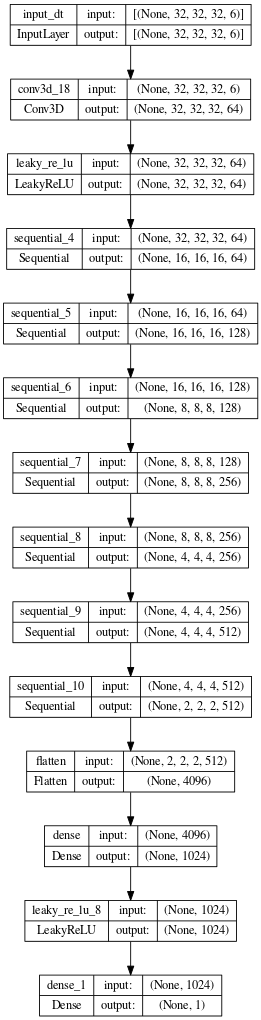

In [8]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [9]:
subjects_lr, subjects_t1, subjects_hr, subjects_masks, [transform_lr, transform_hr] = load_data("../HCPData", subjects, pads = [(8+16, 7+16), (9+8, 9+8), (8+16, 7+16), (0,0)])

Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341
Loading Subject 951457


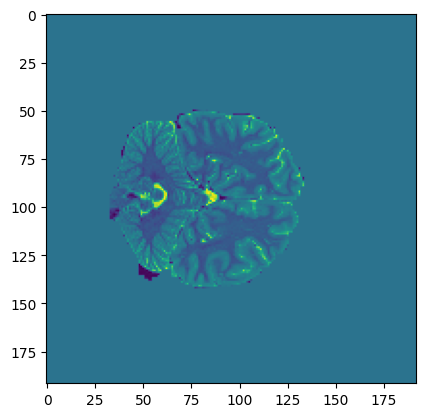

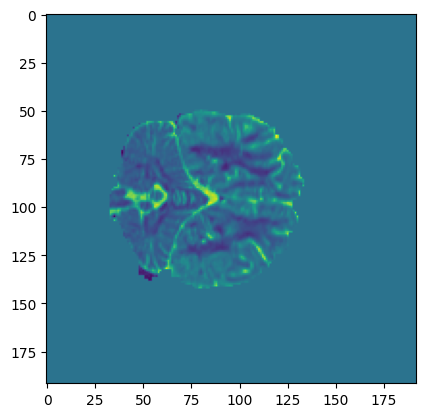

In [10]:
plt.imshow(subjects_t1[7][...,80,:,0])
plt.figure()
plt.imshow(subjects_hr[7][...,80,:,0])

In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):

  real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_real_output), 
                                                      logits=disc_real_output)

  generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(disc_generated_output), 
                                                           logits=disc_generated_output)

  # print(generated_loss)
    
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target, gan_mode = 1):

  gan_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_generated_output,
                                              labels=tf.ones_like(disc_generated_output)))

  # Mean squared error
  # l2_loss = tf.reduce_mean(tf.square(target - gen_output), axis=[1,2,3,4])
  l2_loss = tf.reduce_mean(tf.square(target - gen_output))

  total_gen_loss = l2_loss + gan_mode * gan_loss / LAMBDA

  # total_gen_loss = gan_loss
    
  # total_gen_loss = l2_loss

  return total_gen_loss, gan_loss, l2_loss

In [12]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=50,
#     decay_rate=0.1
# )

class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):

      return self.initial_learning_rate * tf.math.pow(0.5, tf.cast(step//1000, tf.float32))

# optimizer = tf.keras.optimizers.SGD(learning_rate=MyLRSchedule(0.1))

# _lr = LRSchedule(2e-4)

_lr = 2e-5

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=_lr)#, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=_lr)#, beta_1=0.5)

In [13]:
checkpoint_dir = './training_checkpoints_ESRGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_dir, max_to_keep=4)

In [14]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/esrganlambda{}_t2/'.format(LAMBDA) + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [15]:
@tf.function
def train_step(lr_patch, hr_patch, gan_mode=1):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # lr_patch_dti = tf.slice(lr_patch[0], [0, 2, 2, 2, 0], [-1, 7, 7, 7, -1])
      
    generated_images = generator(lr_patch, training=True)
    
    # real_output = discriminator([hr_patch, lr_patch_dti], training=True)
    # fake_output = discriminator([generated_images, lr_patch_dti], training=True)
    real_output = discriminator(hr_patch, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, hr_patch, gan_mode)
    disc_loss = discriminator_loss(real_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  return tf.reduce_mean(gen_total_loss), tf.reduce_mean(gen_gan_loss), tf.reduce_mean(gen_l1_loss), tf.reduce_mean(disc_loss)

@tf.function
def val_step(lr_patch, hr_patch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # lr_patch_dti = tf.slice(lr_patch[0], [0, 2, 2, 2, 0], [-1, 7, 7, 7, -1])
      
    generated_images = generator(lr_patch, training=False)
    
    # real_output = discriminator([hr_patch, lr_patch_dti], training=False)
    # fake_output = discriminator([generated_images, lr_patch_dti], training=False)

    real_output = discriminator(hr_patch, training=False)
    fake_output = discriminator(generated_images, training=False)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, hr_patch)
    disc_loss = discriminator_loss(real_output, fake_output)

  return tf.reduce_mean(gen_total_loss), tf.reduce_mean(gen_gan_loss), tf.reduce_mean(gen_l1_loss), tf.reduce_mean(disc_loss)

In [16]:
# batch_size = 12

# val_size = 6 # Roughly 50%


# def train(data, epochs, c_epoch=0):

#   gan_mode = 1

#   best_cost = np.Inf
    
#   for epoch in range(c_epoch, epochs):

#     metrics = np.zeros(4)
      
#     start = time.time()

#     print("Epoch: {}".format(epoch+1))

#     print("Learning rate:", generator_optimizer.learning_rate.numpy())

#     randsels = np.random.choice(data[0].shape[0], batch_size)

#     train_sels = randsels[:batch_size-val_size]

#     val_sels = randsels[batch_size-val_size:]

#     lr_patches = []
#     t1_patches = []
#     hr_patches = []

#     if (epoch >= epoch // 2):
#         gan_mode = 1

#     for prog, index in enumerate(tqdm(train_sels)):

#             (s, i, j, k) = np.copy(data[0][index])

#             lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

#             lr_patch =  np.copy(data[1][s][::2,::2,::2,:])[
#                                         i - p_size_i : i + p_size_i + e_or_o,
#                                         j - p_size_i : j + p_size_i + e_or_o,
#                                         k - p_size_i : k + p_size_i + e_or_o,:]

#             t1_patch =  np.copy(data[4][s])[
#                                     2*(i - p_size_i) : 2*(i + p_size_i + e_or_o),
#                                     2*(j - p_size_i) : 2*(j + p_size_i + e_or_o),
#                                     2*(k - p_size_i) : 2*(k + p_size_i + e_or_o),:]

        
#             # lr_patch = (lr_patch - np.mean(lr_patch)) / np.std(lr_patch)
#             # t1_patch = (t1_patch - np.mean(t1_patch)) / np.std(t1_patch)


#             lr_patch_samp[...,:6] = lr_patch
#             lr_patch_samp[...,6:] = space_to_depth(t1_patch)

#             # lr_patch = lr_patch_samp
            
#             hr_patch = np.copy(data[2][s])[
#                                     2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
#                                     2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
#                                     2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :]

#             # hr_patch = (hr_patch - np.mean(hr_patch)) / np.std(hr_patch)

#             lr_patches.append(lr_patch)
#             t1_patches.append((t1_patch))
#             # hr_patches.append(space_to_depth(hr_patch, 2))
#             hr_patches.append(hr_patch)
      
#     lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
#     t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
#     hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

#     # print(tf.shape(hr_patches))

#     t_loss = train_step([lr_patches, t1_patches], hr_patches)
#     # t_loss = train_step(lr_patches, hr_patches)
      
#     print('Training L2 Loss is {}'.format(t_loss[2]))

#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', t_loss[0], step=epoch)
#         tf.summary.scalar('gen_gan_loss', t_loss[1], step=epoch)
#         tf.summary.scalar('gen_l1_loss', t_loss[2], step=epoch)
#         tf.summary.scalar('disc_loss', t_loss[3], step=epoch)
    
#     lr_patches = []
#     t1_patches = []
#     hr_patches = []

#     for prog, index in enumerate(tqdm(val_sels)):

#             (s, i, j, k) = np.copy(data[0][index])

#             lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

#             lr_patch =  np.copy(data[1][s][::2,::2,::2,:6])[
#                                         (i - p_size_i) : (i + p_size_i + e_or_o),
#                                         (j - p_size_i) : (j + p_size_i + e_or_o),
#                                         (k - p_size_i) : (k + p_size_i + e_or_o),:]

#             t1_patch =  np.copy(data[4][s])[
#                                     2*(i - p_size_i) : 2*(i + p_size_i + e_or_o),
#                                     2*(j - p_size_i) : 2*(j + p_size_i + e_or_o),
#                                     2*(k - p_size_i) : 2*(k + p_size_i + e_or_o),:]

#             lr_patch_samp[...,:6] = lr_patch
#             lr_patch_samp[...,6:] = space_to_depth(t1_patch)

#             # lr_patch = lr_patch_samp
            
#             hr_patch = np.copy(data[2][s])[
#                                     2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
#                                     2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
#                                     2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :]

#             # hr_patch = (hr_patch - np.mean(hr_patch)) / np.std(hr_patch)

#             lr_patches.append(lr_patch)
#             t1_patches.append((t1_patch))
#             hr_patches.append(hr_patch)
#             # hr_patches.append(space_to_depth(hr_patch, 2))
            
#             continue

#     lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
#     t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
#     hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

#     # output = model_unet([lr_patches, t1_patches], training=False)

#     v_loss = val_step([lr_patches, t1_patches], hr_patches)
#     # v_loss = val_step(lr_patches, hr_patches)
      
#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss_valid', v_loss[0], step=epoch)
#         tf.summary.scalar('gen_gan_loss_valid', v_loss[1], step=epoch)
#         tf.summary.scalar('gen_l1_loss_valid', v_loss[2], step=epoch)
#         tf.summary.scalar('disc_loss_valid', v_loss[3], step=epoch)
      
#     # Save the best validation score
#     if v_loss[2] < best_cost:
#         # checkpoint.save(file_prefix = checkpoint_prefix)
#         manager.save()
#         best_cost = v_loss[2]

#     if (epoch + 1) % 20 == 0:

#         print("Saving Sample Image")
        
#         lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

#         lr_patch = np.copy(data[1][5][::2,::2,::2,:6])[
#                                         (50 - p_size_i) : (50 + p_size_i + e_or_o),
#                                         (40 - p_size_i) : (40 + p_size_i + e_or_o),
#                                         (30 - p_size_i) : (30 + p_size_i + e_or_o),:]

#         t1_patch = np.copy(data[4][5])[
#                                         2*(50 - p_size_i) : 2*(50 + p_size_i + e_or_o),
#                                         2*(40 - p_size_i) : 2*(40 + p_size_i + e_or_o),
#                                         2*(30 - p_size_i) : 2*(30 + p_size_i + e_or_o),:]
        
#         lr_patch_samp[...,:6] = lr_patch
#         lr_patch_samp[...,6:] = space_to_depth(t1_patch)

#         # lr_patch = lr_patch_samp

#         # img = generator(lr_patch[None,...], training=False)[0,...]

#         img = generator([lr_patch[None,...], t1_patch[None,...]], training=False)[0,...]
        
#         # img_recon = depth_to_space(img, 2)
#         img_recon = img
        
#         with summary_writer.as_default():
#             tf.summary.image("Training data", [img_recon[:,:,7,0,None], img_recon[:,:,7,1,None],
#                                                img_recon[:,:,7,2,None], img_recon[:,:,7,3,None],
#                                                img_recon[:,:,7,4,None], img_recon[:,:,7,5,None]], max_outputs=6, step=epoch)

      


#     print('Validation L2 Loss is {}'.format(v_loss[2]))
      
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#     if (epoch + 1) % 10 == 0:
#         clear_output(wait=True)

In [17]:
batch_size = 12

val_size = 6

train_size = 6

def train(data, epochs, c_epoch=0):

  gen_train_mode = False

  best_cost = np.Inf


  n_train_batches = (8000*8)//batch_size
    
  for epoch in range(c_epoch, epochs):

    metrics = np.zeros(4)
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())

    randsels = np.random.choice(data[0].shape[0], data[0].shape[0])

    # print(randsels)

    randsels_train = randsels[:data[0].shape[0]//2]

    randsels_valid = randsels[data[0].shape[0]//2:]

    best_val_cost = np.inf

    for _iter in tqdm(range(n_train_batches)):

        train_sels = randsels_train[_iter*train_size:(_iter+1)*train_size]

        # print(train_sels)
    
        val_sels = randsels_valid[_iter*val_size:(_iter+1)*val_size]
    
        lr_patches = []
        t1_patches = []
        hr_patches = []

        for prog, index in enumerate((train_sels)):
    
                (s, i, j, k) = data[0][index]
    
                # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))
    
                lr_patch = (data[1][s][::ds,::ds,::ds,:])[
                                            i - p_size_i : i + p_size_i,
                                            j - p_size_i : j + p_size_i,
                                            k - p_size_i : k + p_size_i,:]
    
                t1_patch = (data[4][s])[
                                        ds*(i - p_size_i) : ds*(i + p_size_i),
                                        ds*(j - p_size_i) : ds*(j + p_size_i),
                                        ds*(k - p_size_i) : ds*(k + p_size_i),:]
                
                hr_patch = (data[2][s])[
                                        ds*(i - p_size_o) : ds*(i + p_size_o),
                                        ds*(j - p_size_o) : ds*(j + p_size_o),
                                        ds*(k - p_size_o) : ds*(k + p_size_o), :]
    
                lr_patches.append(lr_patch)
                t1_patches.append((t1_patch))
                hr_patches.append((hr_patch))
    
    
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
          
        # t_loss = train_step(lr_patches, hr_patches)

        t_loss = train_step([lr_patches, t1_patches], hr_patches)
        
        # print('Training L2 Loss is {}'.format(t_loss[2]))
    
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', t_loss[0], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_gan_loss', t_loss[1], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_l1_loss', t_loss[2], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('disc_loss', t_loss[3], step=epoch*n_train_batches+_iter)
        
        lr_patches = []
        t1_patches = []
        hr_patches = []
    
        for prog, index in enumerate((val_sels)):
    
                (s, i, j, k) = np.copy(data[0][index])
    
                # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))
    
                lr_patch = (data[1][s][::2,::2,::2,:6])[
                                            (i - p_size_i) : (i + p_size_i),
                                            (j - p_size_i) : (j + p_size_i),
                                            (k - p_size_i) : (k + p_size_i),:]
    
                t1_patch = (data[4][s])[
                                        ds*(i - p_size_i) : ds*(i + p_size_i),
                                        ds*(j - p_size_i) : ds*(j + p_size_i),
                                        ds*(k - p_size_i) : ds*(k + p_size_i),:]
                
                hr_patch = (data[2][s])[
                                        ds*(i - p_size_o) : ds*(i + p_size_o),
                                        ds*(j - p_size_o) : ds*(j + p_size_o),
                                        ds*(k - p_size_o) : ds*(k + p_size_o), :]
    
                lr_patches.append(lr_patch)
                t1_patches.append((t1_patch))
                hr_patches.append((hr_patch))
                
                continue
    
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
        
        # v_loss = val_step(lr_patches, hr_patches)

        v_loss = val_step([lr_patches, t1_patches], hr_patches)
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss_valid', v_loss[0], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_gan_loss_valid', v_loss[1], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_l1_loss_valid', v_loss[2], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('disc_loss_valid', v_loss[3], step=epoch*n_train_batches+_iter)

        if v_loss[2] < best_val_cost:
            best_val_cost = v_loss[2]
      
    # Save the best validation score
    if best_val_cost < best_cost:
        manager.save()
        best_cost = v_loss[2]

    if (epoch + 1) % 5 == 0:

        print("Saving Sample Image")
        
        # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

        lr_patch = np.copy(data[1][5][::2,::2,::2,:6])[
                                        (50 - p_size_i) : (50 + p_size_i + e_or_o),
                                        (40 - p_size_i) : (40 + p_size_i + e_or_o),
                                        (30 - p_size_i) : (30 + p_size_i + e_or_o),:]

        t1_patch = np.copy(data[4][5])[
                                        2*(50 - p_size_i) : 2*(50 + p_size_i + e_or_o),
                                        2*(40 - p_size_i) : 2*(40 + p_size_i + e_or_o),
                                        2*(30 - p_size_i) : 2*(30 + p_size_i + e_or_o),:]

        img = generator([lr_patch[None,...], t1_patch[None,...]], training=False)[0,...]
        
        with summary_writer.as_default():
            tf.summary.image("Training data", [img[:,:,7,0,None], img[:,:,7,1,None],
                                               img[:,:,7,2,None], img[:,:,7,3,None],
                                               img[:,:,7,4,None], img[:,:,7,5,None]], max_outputs=6, step=epoch)

      


    # print('Validation L2 Loss is {}'.format(v_loss[2]))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)


In [18]:
sel_indices = []

for cnt, mask in enumerate(subjects_masks):

    lowres_mask = mask[::2,::2,::2]

    inds = np.array(np.where(lowres_mask != 0), dtype=int).T

    dims = lowres_mask.shape

    iskeep = np.zeros((inds.shape[0], 6), dtype=bool)
    iskeep[:, 0] = (inds[:, 0] - 5) >= 0
    iskeep[:, 1] = (inds[:, 0] + 5) < dims[0]
    iskeep[:, 2] = (inds[:, 1] - 5) >= 0
    iskeep[:, 3] = (inds[:, 1] + 5) < dims[1]
    iskeep[:, 4] = (inds[:, 2] - 5) >= 0
    iskeep[:, 5] = (inds[:, 2] + 5) < dims[2]
    iskeep = np.all(iskeep, axis=1)

    neg_indx = np.where(iskeep == False)
    if neg_indx[0].size > 0:
        print ('Warning: Image', cnt,
               'has some voxels that cannot be used:', len(neg_indx[0]))
    rowlist = np.delete(np.array(range(inds.shape[0])), neg_indx, 0)

    indices = inds[rowlist, :]

    indices = np.append(cnt * np.ones((len(indices),1), dtype=int), indices, axis=-1)
    
    sel_indices.append(indices)


sel_indices = np.concatenate(sel_indices, axis=0)

sel_indices = np.random.permutation(sel_indices)

print(sel_indices.shape)


(667971, 4)


In [19]:
data = [sel_indices, subjects_lr, subjects_hr, subjects_masks, subjects_t1]

In [20]:
print(sel_indices.shape)

(667971, 4)


In [21]:
train(data, 10, c_epoch=0)

Epoch: 1
Learning rate: 2e-05


  0%|                                                  | 0/5333 [00:00<?, ?it/s]2023-09-21 23:28:41.356708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-21 23:28:42.733691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-21 23:28:43.264734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef9205e2820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-21 23:28:43.264751: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-09-21 23:28:43.268067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-21 23:28:43.398961: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Time for epoch 1 is 696.5979402065277 sec
Epoch: 2
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:22<00:00,  7.82it/s]


Time for epoch 2 is 685.3620364665985 sec
Epoch: 3
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:09<00:00,  7.97it/s]


Time for epoch 3 is 672.8397815227509 sec
Epoch: 4
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:32<00:00,  7.71it/s]


Time for epoch 4 is 695.5666103363037 sec
Epoch: 5
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:25<00:00,  7.78it/s]


Saving Sample Image
Time for epoch 5 is 689.3065423965454 sec
Epoch: 6
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:24<00:00,  7.79it/s]


Time for epoch 6 is 688.1735947132111 sec
Epoch: 7
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:31<00:00,  7.71it/s]


Time for epoch 7 is 694.8784766197205 sec
Epoch: 8
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:43<00:00,  7.58it/s]


Time for epoch 8 is 707.0681371688843 sec
Epoch: 9
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:33<00:00,  7.69it/s]


Time for epoch 9 is 697.0398516654968 sec
Epoch: 10
Learning rate: 2e-05


100%|███████████████████████████████████████| 5333/5333 [11:13<00:00,  7.92it/s]


Saving Sample Image
Time for epoch 10 is 677.0854506492615 sec


In [22]:
lr_patch = np.copy(data[1][5][::2,::2,::2,:6])[
                                (50 - p_size_i) : (50 + p_size_i + e_or_o),
                                (40 - p_size_i) : (40 + p_size_i + e_or_o),
                                (30 - p_size_i) : (30 + p_size_i + e_or_o),:]

hr_patch = np.copy(data[2][5])[
                                2*(50 - p_size_o) : 2*(50 + p_size_o + e_or_o),
                                2*(40 - p_size_o) : 2*(40 + p_size_o + e_or_o),
                                2*(30 - p_size_o) : 2*(30 + p_size_o + e_or_o),:]

t1_patch = np.copy(data[4][5])[
                                2*(50 - p_size_i) : 2*(50 + p_size_i + e_or_o),
                                2*(40 - p_size_i) : 2*(40 + p_size_i + e_or_o),
                                2*(30 - p_size_i) : 2*(30 + p_size_i + e_or_o),:]

# lr_patch = lr_patch_samp

# img = generator(lr_patch[None,...], training=False)[0,...]

img = generator([lr_patch[None,...], t1_patch[None,...]], training=False)

print(tf.nn.sigmoid(discriminator(img)))
print(tf.nn.sigmoid(discriminator(hr_patch[None,...])))

tf.Tensor([[0.7508188]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7001451]], shape=(1, 1), dtype=float32)


In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
generator.save('Model/esrgan_t2')
# discriminator.save('Model/discriminator{}x_shuffle_out'.format(2*p_size_o + e_or_o))

INFO:tensorflow:Assets written to: Model/esrgan_t2/assets


INFO:tensorflow:Assets written to: Model/esrgan_t2/assets


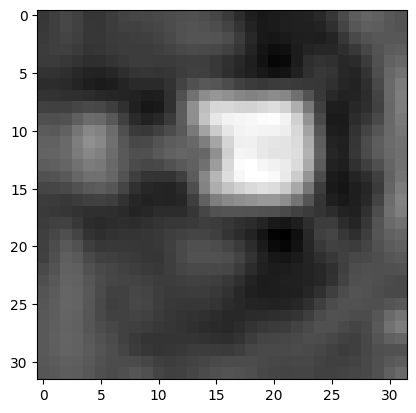

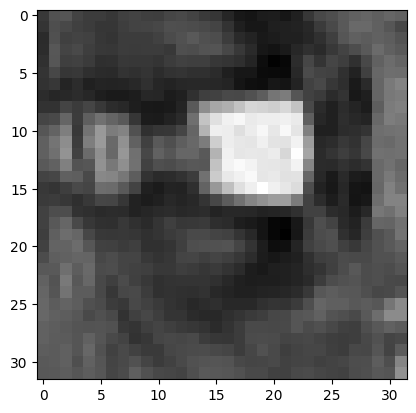

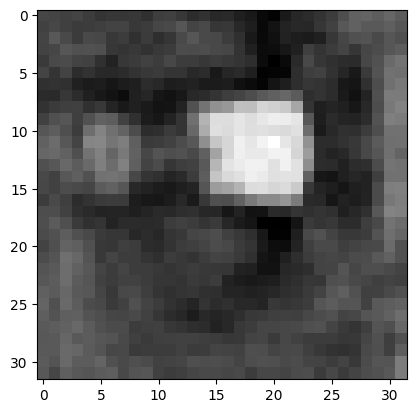

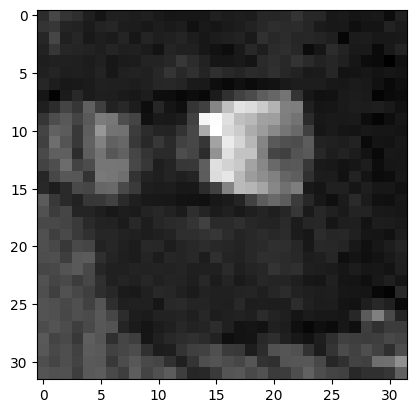

In [25]:
s = 5
i = 50
j = 40
k = 30

shuffle_indices = [(c, b, a)
                   for a in range(2)
                   for b in range(2)
                   for c in range(2)]

upsampling_rate = 2

hr_patch = np.copy(data[2][s][
                        2*(i - p_size_o - e_or_o) : 2*(i + p_size_o),
                        2*(j - p_size_o - e_or_o) : 2*(j + p_size_o),
                        2*(k - p_size_o - e_or_o) : 2*(k + p_size_o), :]) * \
           np.copy((data[3][s])[
                        2*(i - p_size_o - e_or_o) : 2*(i + p_size_o),
                        2*(j - p_size_o - e_or_o) : 2*(j + p_size_o),
                        2*(k - p_size_o - e_or_o) : 2*(k + p_size_o), None])

lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

lr_patch_samp[...,:6] = (data[1][s][::2,::2,::2,:6])[
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i,:6]

# lr_mean = np.mean(lr_patch_samp[...,:6])
# lr_std = np.std(lr_patch_samp[...,:6])

# lr_patch_samp[...,:6] = (lr_patch_samp[...,:6] - lr_mean) / lr_std

lr_patch_samp[...,6:] = space_to_depth(np.copy(data[4][s])[
                                        2*(i - p_size_i - e_or_o) : 2*(i + p_size_i),
                                        2*(j - p_size_i - e_or_o) : 2*(j + p_size_i),
                                        2*(k - p_size_i - e_or_o) : 2*(k + p_size_i),:])

t1_patch = np.copy(data[4][s])[
                                        2*(i - p_size_i - e_or_o) : 2*(i + p_size_i),
                                        2*(j - p_size_i - e_or_o) : 2*(j + p_size_i),
                                        2*(k - p_size_i - e_or_o) : 2*(k + p_size_i),:]

# lr_patch_samp[...,6:] = (lr_patch_samp[...,6:] - np.mean(lr_patch_samp[...,6:])) / np.std(lr_patch_samp[...,6:])

# lr_patch = lr_patch_samp[...,:6]

lr_patch = lr_patch_samp[...,:6]

# lr_patch[lr_mask == 0] = 0

generated_image = generator([lr_patch_samp[None,...,:6],t1_patch[None,...]], training=False)
# generated_image = generator(lr_patch[None,...], training=False)

nch = 6

# deshuf_result = depth_to_space(generated_image[0,...], upsampling_rate=2)

deshuf_result = generated_image[0,...]
channel = 0

plt.imshow(zoom(lr_patch_samp[:,:,7,channel],2), cmap='gray') 
plt.figure()
plt.imshow(hr_patch[:,:,15,channel], cmap='gray')
plt.figure()
plt.imshow(deshuf_result[:,:,15,channel], cmap='gray')
plt.figure()
plt.imshow(depth_to_space(lr_patch_samp[...,6:])[:,:,15,0], cmap='gray')

# fig = plt.figure(figsize=(11,16))

# for c in range(6):
#     for i in range(8):
#         fig.add_subplot(6,8,(i+1)+8*c)
#         plt.imshow(generated_image[0,:,:,4,i+(8*c)], cmap='gray')

In [26]:
# subjects_lr
# subjects_hr# subjects_masks

s = 6

lowres_input = data[1][s][::2,::2,::2,:]

(xsize, ysize, zsize, comp) = lowres_input.shape

print(xsize * 2, ysize * 2, zsize * 2)

result_image = np.zeros((xsize*2, ysize*2, zsize*2, comp))

# result_image = np.zeros((xsize, ysize, zsize, comp))

# recon_indx = [(i, j, k) for k in np.arange(p_size_i+e_or_o,
#                                            zsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o)
#                         for j in np.arange(p_size_i+e_or_o,
#                                            ysize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o)
#                         for i in np.arange(p_size_i+e_or_o,
#                                            xsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o)]

recon_indx = [(i, j, k) for k in np.arange(p_size_i,
                                           zsize-p_size_i,
                                           2*p_size_o-2)
                        for j in np.arange(p_size_i,
                                           ysize-p_size_i,
                                           2*p_size_o-2)
                        for i in np.arange(p_size_i,
                                           xsize-p_size_i,
                                           2*p_size_o-2)]

for (i, j, k) in tqdm(recon_indx):

    if (i - p_size_i < 0 or j - p_size_i < 0 or k - p_size_i < 0):
        continue

    if (i + p_size_i >= xsize or j + p_size_i >= ysize or k + p_size_i >= zsize):
        continue

    # print(i - p_size_i, i + p_size_i)
    # print(j - p_size_i, j + p_size_i)
    # print(k - p_size_i, k + p_size_i)

    if np.max(data[3][s][::2,::2,::2][i - p_size_i : i + p_size_i,
                                      j - p_size_i : j + p_size_i,
                                      k - p_size_i : k + p_size_i]) != 1:
        continue

    lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

    lr_patch =  np.copy(data[1][s][::2,::2,::2,:6])[
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i,:]

    t1_patch =  np.copy(data[4][s])[
                        2*(i - p_size_i - e_or_o) : 2*(i + p_size_i),
                        2*(j - p_size_i - e_or_o) : 2*(j + p_size_i),
                        2*(k - p_size_i - e_or_o) : 2*(k + p_size_i),:]

    lr_patch_samp[...,:6] = lr_patch

    # lr_patch_samp[...,6:] = t1_patch

    # lr_patch = lr_patch_samp
    

    # output_patch = generator([lr_patch_samp[None,...,:6], lr_patch_samp[None,...,6:]], training=False)
    # output_patch = generator(lr_patch_samp[None,...], training=False)
    output_patch = generator([lr_patch[None,...], t1_patch[None,...]], training=False)

    # print(depth_to_space(output_patch, upsampling_rate=2).shape)

    result_image[2*(i - p_size_o + 1) : 2*(i + p_size_o - 1),
                 2*(j - p_size_o + 1) : 2*(j + p_size_o - 1),
                 2*(k - p_size_o + 1) : 2*(k + p_size_o - 1), :] = output_patch[0,2:-2,2:-2,2:-2,:]
    # result_image[2*(i - p_size_o - e_or_o) : 2*(i + p_size_o),
    #              2*(j - p_size_o - e_or_o) : 2*(j + p_size_o),
    #              2*(k - p_size_o - e_or_o) : 2*(k + p_size_o), :] + output_patch[0,...]

# result_image[subjects_masks[6] == 0] = 0
    

192 208 192


100%|█████████████████████████████████████████| 252/252 [00:06<00:00, 40.54it/s]


In [27]:
result_image[subjects_masks[6] == 0] = 0

In [28]:
lr_interp = np.zeros(subjects_hr[6].shape)

for ch in range(6):
    lr_interp[...,ch] = zoom(np.copy(subjects_lr[6][...,ch])[::ds,::ds,::ds], ds, order=3) # * transform_lr[6][ch,1] + transform_lr[6][ch,0])[::ds,::ds,::ds]

lr_interp[subjects_masks[6] == 0] = 0

In [29]:
print(tf.reduce_mean(tf.square(subjects_hr[6] - lr_interp)))
print(tf.reduce_mean(tf.square(subjects_hr[6] - result_image)))

tf.Tensor(0.01270624782345847, shape=(), dtype=float64)
tf.Tensor(0.006696816671655126, shape=(), dtype=float64)


(96, 104)


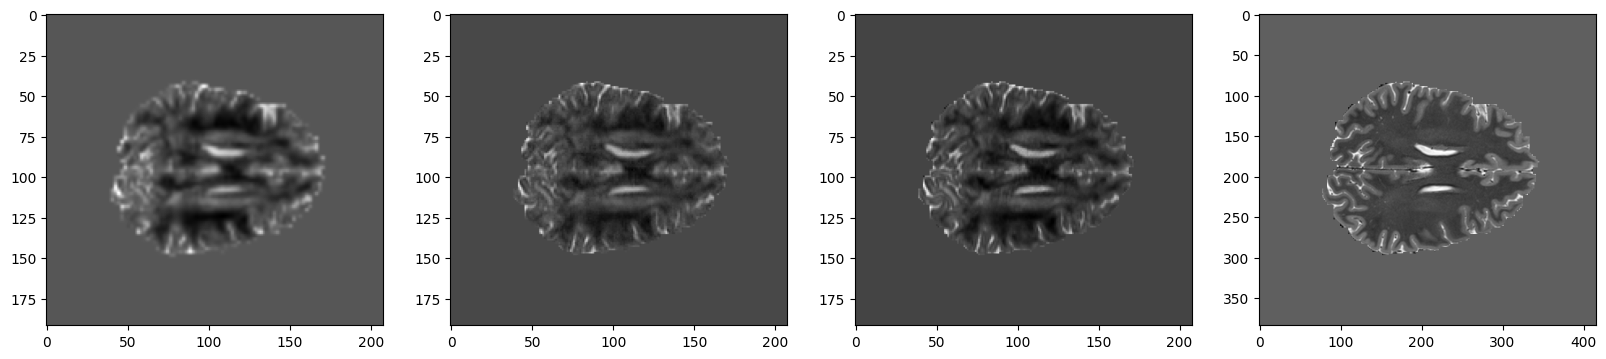

In [30]:
zdim = 100
channel = 5

print(subjects_lr[6][::2,::2,zdim,channel].shape)

x = 80 
y = 75

lr_out = cv2.resize(subjects_lr[6][::2,::2,zdim,channel]
            *transform_lr[6][channel,1] + transform_lr[6][channel,0], (104*2, 96*2))

hr_out = result_image[:,:,zdim,channel]*transform_lr[6][channel,1] + transform_lr[6][channel,0]

hr_act = subjects_hr[6][:,:,zdim,channel]*transform_hr[6][channel,1] + transform_lr[6][channel,0]

# lr_out = cv2.resize(subjects_lr[6][::2,::2,zdim,channel]
#             *transform_lr[6][0] + transform_lr[6][1], (104*2, 96*2))

# hr_out = result_image[:,:,zdim,channel]*transform_lr[6][0] + transform_lr[6][1]

# hr_act = subjects_hr[6][:,:,zdim,channel]*transform_hr[6][0] + transform_hr[6][1]

fig = plt.figure(figsize=(20,20))

fig.add_subplot(1,4,1)
plt.imshow(lr_out, cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(hr_out, cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(hr_act, cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(depth_to_space(subjects_t1[6])[:,:,zdim*2,0], cmap='gray')

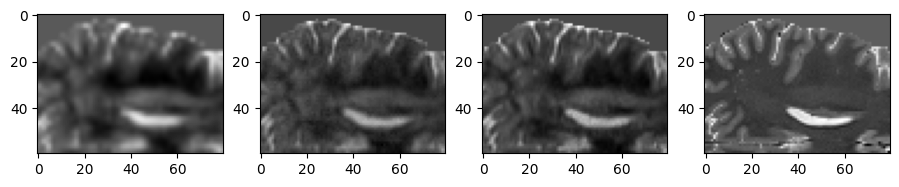

In [31]:
fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,4,1)
plt.imshow(lr_out[40:100,60:140], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(hr_out[40:100,60:140], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(hr_act[40:100,60:140], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(subjects_t1[6][:,:,zdim-1,channel][40:100,60:140], cmap='gray')

In [32]:
lr_act = np.pad(subjects_lr[6], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_act = np.pad(subjects_hr[6], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_pred = np.pad(result_image, ((0,0), (0,0), (0,0), (2,0)), mode='constant')

for ch in range(2,8):
    lr_act[...,ch] = zoom(subjects_lr[6][::2,::2,::2,ch-2], 2) * transform_lr[6][ch-2,1] + transform_lr[6][ch-2,0]
    lr_act[subjects_masks[6] == 0] = 0
    hr_act[...,ch] = subjects_hr[6][...,ch-2] * transform_hr[6][ch-2,1] + transform_hr[6][ch-2,0]
    hr_act[subjects_masks[6] == 0] = 0
    hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[6][ch-2,1] + transform_lr[6][ch-2,0]
    hr_pred[subjects_masks[6] == 0] = 0

In [33]:
print(tf.reduce_mean(tf.square(subjects_hr[6] - subjects_lr[6])))
print(tf.reduce_mean(tf.square(subjects_hr[6] - result_image[6])))

print(np.mean(np.square(hr_act - lr_act)))
print(np.mean(np.square(hr_act - hr_pred)))

tf.Tensor(0.02097934043120084, shape=(), dtype=float64)
tf.Tensor(0.09408465002337073, shape=(), dtype=float64)
3.8759653532789264e-10
1.8854286649315662e-10


In [34]:
import data_utils

# importlib.reload(data_utils)

In [35]:
[XSIZE, YSIZE, ZSIZE, dim] = hr_act.shape


md_lr_i, fa_lr_i, cfa_lr_i = data_utils.calc_MD_FA_CFA(lr_act[::2,::2,::2,:], XSIZE//2, YSIZE//2, ZSIZE//2)
md_lr, fa_lr, cfa_lr = data_utils.calc_MD_FA_CFA(lr_act, XSIZE, YSIZE, ZSIZE)
md_hr, fa_hr, cfa_hr = data_utils.calc_MD_FA_CFA(hr_act, XSIZE, YSIZE, ZSIZE)
md_gen, fa_gen, cfa_gen = data_utils.calc_MD_FA_CFA(hr_pred, XSIZE, YSIZE, ZSIZE)

100%|█████████████████████████████████████████| 192/192 [00:09<00:00, 20.46it/s]


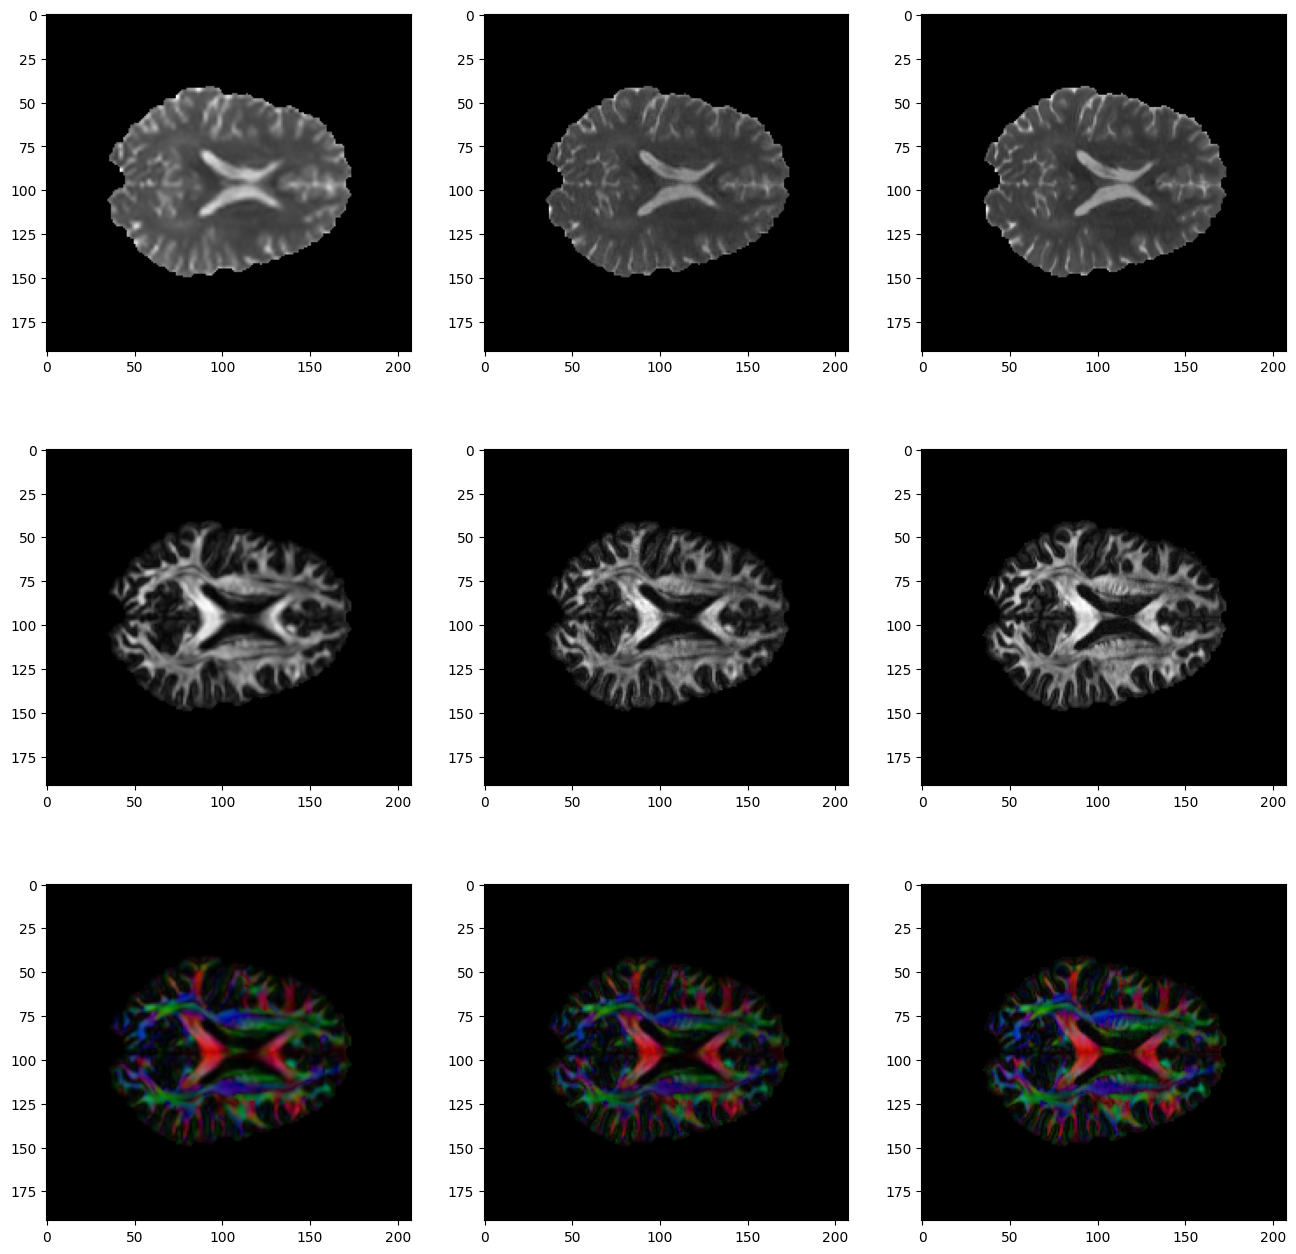

In [36]:
zdim = 96

fig = plt.figure(figsize=(16,16))

fig.add_subplot(3,3,1)
plt.imshow(md_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,2)
plt.imshow(md_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,3)
plt.imshow(md_hr[:,:,zdim], cmap='gray')


fig.add_subplot(3,3,4)
plt.imshow(fa_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,5)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,6)
plt.imshow(fa_hr[:,:,zdim], cmap='gray')

fig.add_subplot(3,3,7)
plt.imshow(cfa_lr[:,:,zdim], vmax=1)
fig.add_subplot(3,3,8)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)
fig.add_subplot(3,3,9)
plt.imshow(cfa_hr[:,:,zdim], vmax=1)